# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} missingno


Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda:
#
missingno                 0.4.1                      py_0    conda-forge


In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython import display
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import heapq

%matplotlib inline


In [3]:
def conversion(str):
    '''
    Function is tranform a string to integer

    INPUT: String. e.g. '1','0','X','XX'

    OUTPUT: cast the possible string representation of a number to intger and 
    return the integer e.g. 0,1 or return the original string 'X','XX' 
    '''
    try:
        return int(str)
    except:
        return str

In [4]:
def get_missing_unknown_tokens(str):
    '''
    Function to transform a string containing missing or unknown tokens for fetures to a 
    list of tokens

    INPUT: String. e.g. '[1,0,X,XX]'

    OUTPUT: list e.g. [1,0,'X','XX']
    '''    
    new_str = str.strip("[]").split(",")
    arr = []
    for x in new_str:
        arr.append(conversion(x))
    
    return arr

In [5]:
def num_missing(df_col,feat_info):
    '''
    Function calculate the count and percentage of values labeled as missing or unknown or nans
    and sum of these calculated values.

    INPUT: String. e.g. A dataframe column and feature_info dataframe
    
    Output: Six float values

    '''    
    nan_values = sum(df_col.isnull())
    nan_values_percent = (nan_values/len(df_col)*100).round(2)
    
    tokens = get_missing_unknown_tokens(feat_info.loc[str(df_col.name)]['missing_or_unknown'])
    mutotal = 0
    for t in tokens:
        missing_unknown_values = sum(df_col==t)
        mutotal = mutotal + missing_unknown_values
        
    missing_unknown_values_percent = (mutotal/len(df_col)*100).round(2)
    
    total = mutotal + nan_values
    total_percent = (total/len(df_col)*100).round(2)
    

    return mutotal, missing_unknown_values_percent,nan_values,nan_values_percent,total,total_percent



In [6]:
def get_missing_value_stats(df,feat_info):
    '''
    Function calculate the stats for a dataframe. Stats are counts and percentages of values labeled as 
    missing or unknown or nans and sum of these calculated values.

    INPUT: String. e.g. A dataframe of demographic data and feature_info dataframe
    
    Output: Dataframe 
    '''        
    total_missing_stats = df.apply(num_missing, axis=0,args = (feat_info,)) #axis=0 defines that function is to be applied on each column
    total_missing_stats_df = pd.DataFrame(list(total_missing_stats))
    total_missing_stats_df.index = total_missing_stats.index
    total_missing_stats_df.columns = ['missing_unknown_values', 'missing_unknown_values_percent','nan_values','nan_values_percent','total','total_percent']
    total_missing_stats_final_df = total_missing_stats_df[total_missing_stats_df['total']!=0].sort_values('total_percent', ascending=False)
    
    return total_missing_stats_final_df

In [7]:
def convert_missing(df,feat_info):
    '''
    Function converts the missing or unknown labeled values to nans.

    INPUT: String. e.g. Demographic dataframe and feature_info dataframe
    
    Output: Dataframe with nans
    '''      
    for col in df.columns:
        tokens = get_missing_unknown_tokens(feat_info.loc[col]['missing_or_unknown'])
        df[col] = df[col].replace(tokens,np.nan)
        

    return df

In [8]:
def get_column_type_list(df,feat_info,column_type):
    '''
    Function computes the list of columns in a dataframe for a given data type

    INPUT: String. e.g. Demographic dataframe and feature_info dataframe and a string describing
    data type like 'categorical', 'mixed'
    
    Output: list 
    '''          
    column_type_list = []
    for col in df.columns:
        if(feat_info.loc[col].type == column_type):
            column_type_list.append(col)
    
    return column_type_list


In [9]:
def create_decade_column(df):
    '''
    Function creates a new column for decade in a dataframe using the 'PRAEGENDE_JUGENDJAHRE' column.

    INPUT: String. e.g. Demographic dataframe
    
    Output: Demographic dataframe containing a column representing Decade
    '''          
    decade_40s = pd.Interval(pd.Timestamp('1940-01-01'),pd.Timestamp('1949-12-31'),closed='both')
    decade_50s = pd.Interval(pd.Timestamp('1950-01-01'),pd.Timestamp('1959-12-31'),closed='both')
    decade_60s = pd.Interval(pd.Timestamp('1960-01-01'),pd.Timestamp('1969-12-31'),closed='both')
    decade_70s = pd.Interval(pd.Timestamp('1970-01-01'),pd.Timestamp('1979-12-31'),closed='both')
    decade_80s = pd.Interval(pd.Timestamp('1980-01-01'),pd.Timestamp('1989-12-31'),closed='both')
    decade_90s = pd.Interval(pd.Timestamp('1990-01-01'),pd.Timestamp('1999-12-31'),closed='both')
    df['Decade'] = 0
    df.Decade.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1, 2])] = decade_40s
    df.Decade.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([3, 4])] = decade_50s
    df.Decade.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([5, 6, 7])] = decade_60s
    df.Decade.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([8, 9])] = decade_70s
    df.Decade.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([10, 11, 12, 13])] = decade_80s
    df.Decade.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([14, 15])] = decade_90s

    return df

In [10]:
def create_mainstream_column(df):
    '''
    Function creates a new column for Mainstream in a dataframe using the 'PRAEGENDE_JUGENDJAHRE' column.

    INPUT: String. e.g. Demographic dataframe
    
    Output: Demographic dataframe including a column representing whether PRAEGENDE has a value Mainstream or not
    '''              
    df['Mainstream'] = 0
    df.Mainstream.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1, 3, 5, 8,10, 12, 14])] = 1
    
    return df

In [11]:
def create_plz8_business_column(df):
    '''
    Function creates a new column for PLZ8_business in a dataframe using the 'PLZ8_BAUMAX' column.

    INPUT: String. e.g. Demographic dataframe
    
    Output: Demographic dataframe including a column representing whether PLZ8_Region consists of mostly business building
    '''              
    df['PLZ8_business'] = 0
    df.PLZ8_business.loc[df['PLZ8_BAUMAX']==5] = 1
    
    return df    

In [12]:
def create_wealth_column(df):
    '''
    Function creates a new column for Wealth in a dataframe using the 'CAMEO_INTL_2015' column.

    INPUT: String. e.g. Demographic dataframe
    
    Output: Demographic dataframe including a column representing Wealth
    '''      
    df['Wealth'] = 1
    df.CAMEO_INTL_2015 = df.CAMEO_INTL_2015.astype(int)
    df.Wealth.loc[df['CAMEO_INTL_2015'].isin([21,22,23,24,25])] = 2
    df.Wealth.loc[df['CAMEO_INTL_2015'].isin([31,32,33,34,35])] = 3
    df.Wealth.loc[df['CAMEO_INTL_2015'].isin([41,42,43,44,45])] = 4
    df.Wealth.loc[df['CAMEO_INTL_2015'].isin([51,52,53,54,55])] = 5
    
    return df

In [13]:
def create_life_typology_column(df):
    '''
    Function creates a new column for Life typology in a dataframe using the 'CAMEO_INTL_2015' column.

    INPUT: String. e.g. Demographic dataframe
    
    Output: Demographic dataframe including a column representing life typology
    '''        
    df['Life_typology'] = 0
    df.CAMEO_INTL_2015 = df.CAMEO_INTL_2015.astype(int)
    df.Life_typology.loc[df['CAMEO_INTL_2015'].isin([11,21,31,41,51])] = 1
    df.Life_typology.loc[df['CAMEO_INTL_2015'].isin([12,22,32,42,52])] = 2
    df.Life_typology.loc[df['CAMEO_INTL_2015'].isin([13,23,33,43,53])] = 3
    df.Life_typology.loc[df['CAMEO_INTL_2015'].isin([14,24,34,44,54])] = 4
    df.Life_typology.loc[df['CAMEO_INTL_2015'].isin([15,25,35,45,55])] = 5    
    
    return df

In [14]:
def create_wohnlage_rural_column(df):
    '''
    Function creates a new column for Life typology in a dataframe using the 'CAMEO_INTL_2015' column.

    INPUT: String. e.g. Demographic dataframe
    
    Output: Demographic dataframe including a column representing life typology
    '''        
    df['Wohnlage_rural'] = 0
    df.Wohnlage_rural.loc[df['WOHNLAGE'].isin([7,8])] = 1
    
    ## removing rural neighborhood information to make an ordinal variable
    df.WOHNLAGE.loc[df['WOHNLAGE'].isin([7,8])] = 0
    
    return df    

In [15]:
def do_pca(n_components, data):
    '''
    
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca



In [16]:

def sandwich(df, rows=3):
    '''
    https://gist.github.com/roycoding/bbecda07b594870a878f2f71f9fb15a8
    Display n rows of head and tail of dataframe.
    Input:
        df - dataframe of interest
        rows - integer number of rows from each end of dataframe to display
    Output:
        dataframe
    '''

    return pd.concat([df.head(rows),  df.tail(rows)])

In [17]:
def pca_component_analysis(df,pca_component,n):
    new_df = pd.DataFrame()
    new_df['Feature'] = df.columns
    new_df['Feature_weight'] = pca_component
    
    result = new_df.sort_values('Feature_weight',ascending = 0)
    
    return sandwich(result,n)

In [18]:
def plot_pca_component(df):
    sns.set(style="whitegrid")
    plt.subplots(figsize=(15,5))
    ax = sns.barplot(y=df['Feature'], x=df['Feature_weight'])


In [19]:
def multiple_pca_component_analysis(df,pca_component_list,n):
    result_list = []
    for pca_component in pca_component_list:
        new_df = pd.DataFrame()
        new_df['Feature'] = df.columns
        new_df['Feature_weight'] = pca_component

        result = new_df.sort_values('Feature_weight',ascending = 0)
        result = sandwich(result,n)
        result_list.append(result)

    return result_list

In [20]:
def plot_multiple_pca_components(df,k,indices):
    res = "Top 3 Components contribution for cluster "+str(k)
    fig, ax =plt.subplots(figsize=(15,5),ncols=3, nrows=1)
    fig.suptitle(res)
    
    a = sns.barplot(x=df[0]['Feature'], y=df[0]['Feature_weight'], ax=ax[0])
    ax[0].set_title("Component "+str(indices[0]))
    [tick.set_rotation(60) for tick in a.get_xticklabels()]
    
    b = sns.barplot(x=df[1]['Feature'], y=df[1]['Feature_weight'], ax=ax[1])
    ax[1].set_title("Component "+str(indices[1]))
    [tick.set_rotation(60) for tick in b.get_xticklabels()]
    
    c = sns.barplot(x=df[2]['Feature'], y=df[2]['Feature_weight'], ax=ax[2])
    ax[2].set_title("Component "+str(indices[2]))
    [tick.set_rotation(60) for tick in c.get_xticklabels()]

def rows_stats(df):
    total = len(df)
    nan_data = df[df.isnull().any(axis=1)]
    nan_data_total = len(nan_data)
    nan_data_percentage = nan_data_total/total*100
    no_nan_data_total = (azdias_copy.isnull().sum(axis=1)==0).sum()
    
    print("Total Number of rows                       ",total)
    print("Total Number of rows with atleast one nan  ",nan_data_total)
    print("Total Number of rows without any nan       ",no_nan_data_total)
    print("------------------------------------------------------")
    print("Percentage of rows with atleast one nan",nan_data_percentage)    
    
    
def analyze_nan_rows(df,low_thresh,high_thresh):
    df_lnans = df[df.isnull().sum(axis=1)<=low_thresh]
    df_mnans = df[(df.isnull().sum(axis=1)>low_thresh) & (df.isnull().sum(axis=1)<=high_thresh)]
    df_hnans = df[df.isnull().sum(axis=1)>high_thresh]
    
    total = len(df)
    print("Percentage of rows with missing values less then or euqal to "+str(low_thresh)+" is ",len(df_lnans)/total*100)
    print("Percentage of rows with missing values between "+str(low_thresh)+" and "+str(high_thresh)+" is ",len(df_mnans)/total*100)
    print("Percentage of rows with missing values more then "+str(high_thresh)+" is ",len(df_hnans)/total*100)
    
    return df_lnans,df_mnans, df_hnans 


def create_subsets(df,thresh):
    df_lnans = df[df.isnull().sum(axis=1)<=thresh]
    df_hnans = df[df.isnull().sum(axis=1)>thresh]
    
    return df_lnans,df_hnans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [21]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",';')


In [22]:

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",';')

In [23]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("Number of rows are: ", azdias.shape[0],"and number of columns are: ", azdias.shape[1])
print(azdias.head(5))

Number of rows are:  891221 and number of columns are:  85
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3 

In [24]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [25]:
feat_info.index = azdias.columns

In [26]:
example = get_missing_unknown_tokens('[1,-1,0,1,X,XX]')
example

[1, -1, 0, 1, 'X', 'XX']

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [27]:
azdias= convert_missing(azdias,feat_info)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [28]:
stats = get_missing_value_stats(azdias,feat_info)

In [29]:
stats

,missing_unknown_values,missing_unknown_values_percent,nan_values,nan_values_percent,total,total_percent
TITEL_KZ,0,0.0,889061,99.76,889061,99.76
AGER_TYP,0,0.0,685843,76.96,685843,76.96
KK_KUNDENTYP,0,0.0,584612,65.60,584612,65.60
KBA05_BAUMAX,0,0.0,476524,53.47,476524,53.47
GEBURTSJAHR,0,0.0,392318,44.02,392318,44.02
ALTER_HH,0,0.0,310267,34.81,310267,34.81
KKK,0,0.0,158064,17.74,158064,17.74
REGIOTYP,0,0.0,158064,17.74,158064,17.74
W_KEIT_KIND_HH,0,0.0,147988,16.61,147988,16.61
KBA05_ANTG3,0,0.0,133324,14.96,133324,14.96


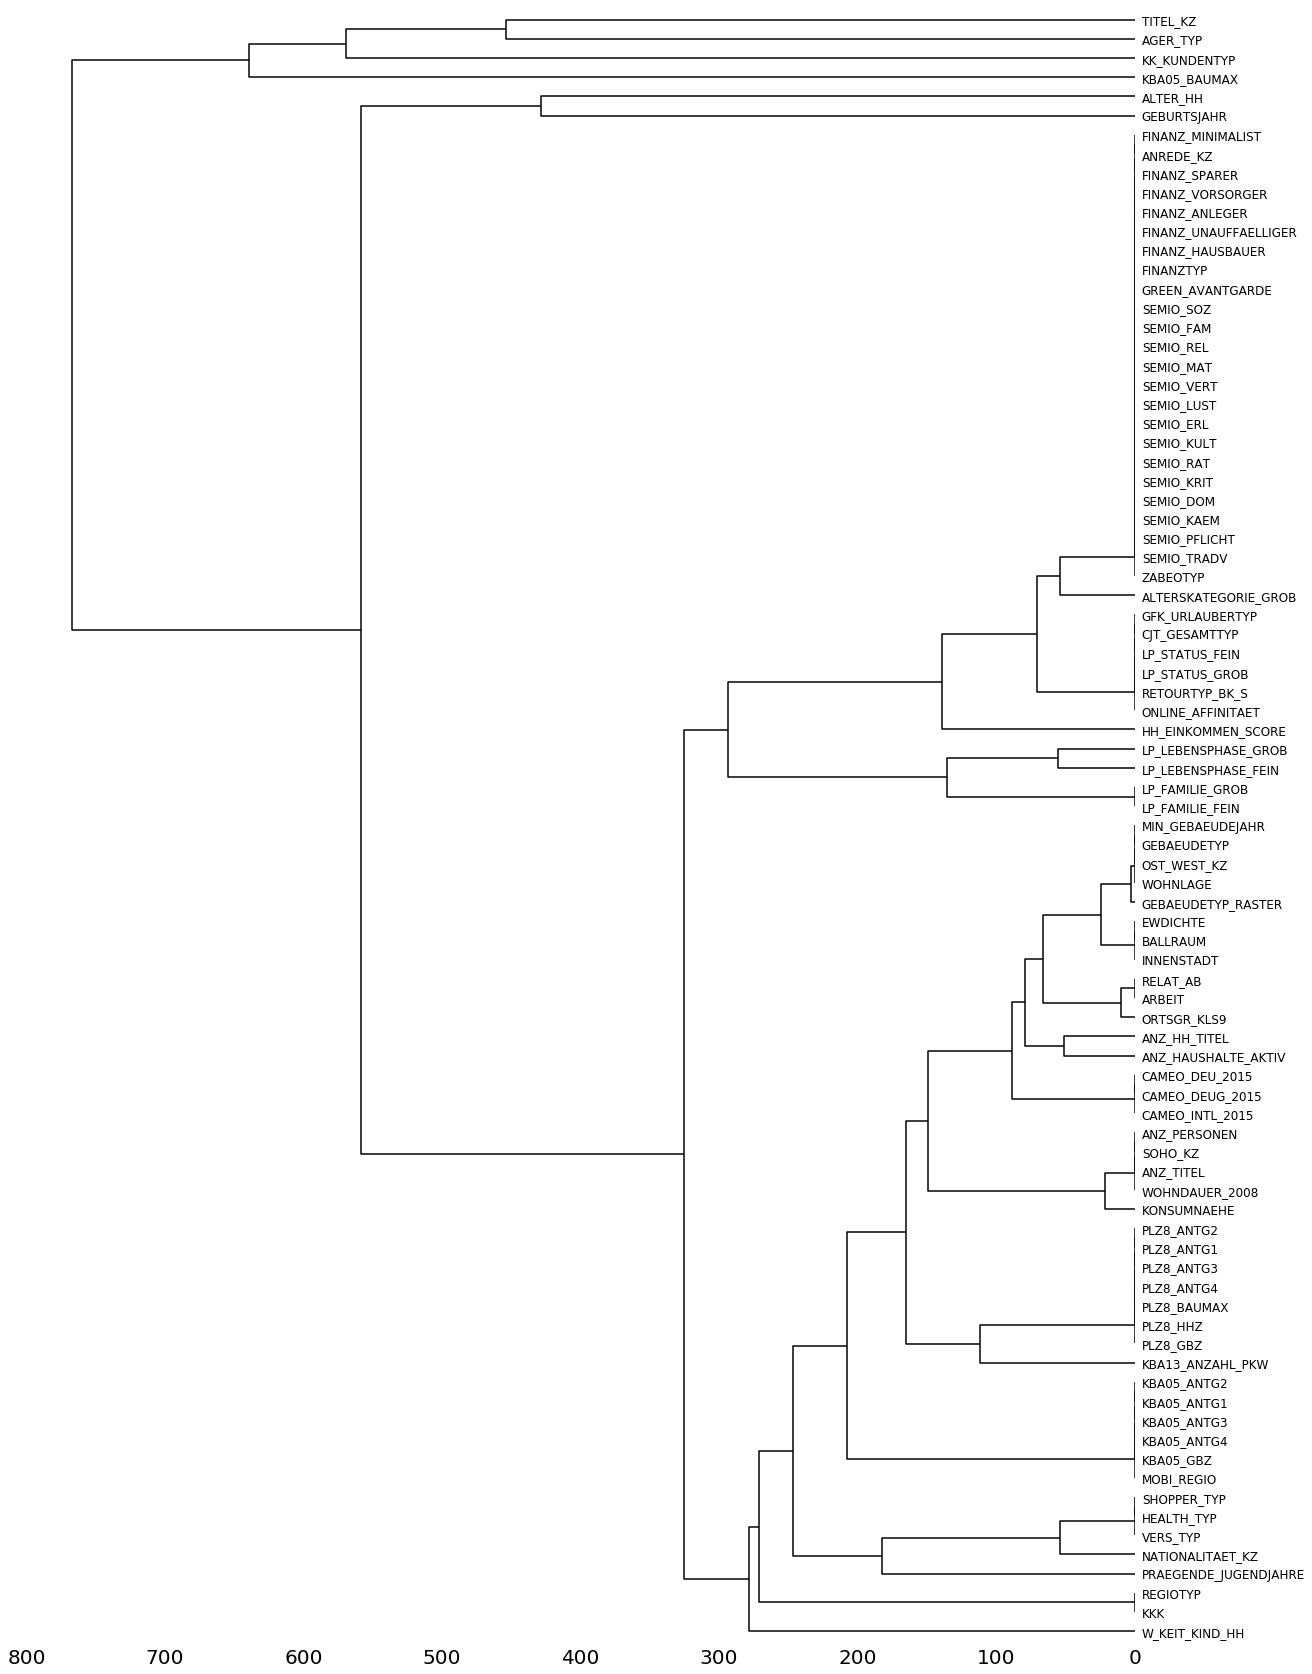

In [30]:
msno.dendrogram(azdias, inline=True, fontsize=12, figsize=(20,30))

In [31]:
stats.head(6).index

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [32]:

azdias_copy = azdias.copy()

In [33]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.



azdias_copy.drop(stats.head(6).index, axis=1, inplace=True)

In [34]:
azdias_copy.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

## Out of 85 columns, 61 columns have missing data. However, six of these columns has more then 30% of the data missing and I will consider those outliers. These columns are:
    
| Column Name   | Description           | Missing Percentage  |
| ------------- |:-------------:| -----:|
| TITEL_KZ      | Academic title flag | 99.76% |
| AGER_TYP       | Best-ager typology      |   76.96% |
| KK_KUNDENTYP | Consumer pattern over past 12 months      |    65.60% |
| KBA05_BAUMAX      | Most common building type within the microcell | 53.47% |
| GEBURTSJAHR       | Year of birth      |   44.02% |
| ALTER_HH | Birthdate of head of household      |    34.81% |


## There are different subsets of columns with the same number of nans, as it can be seen in the table and dendogram visualized above. 
- For example, all these columns, 
        'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP','FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER','FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER','FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN','LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB','NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT','SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT','SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV','SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP' have the same number of nan values. 
- Table and Bottom of the dendogram shows the colmns KKK and RegioTyp contains the same number of nans which comprises 17.74% of the data in those column.
- Similarly, these columns 
        'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO' contain 14.96% of the data in these columns as nan.
- More such patterns can be visulaized from the table and dendogram.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [35]:
rows_stats(azdias_copy)


Total Number of rows                        891221
Total Number of rows with atleast one nan   268012
Total Number of rows without any nan        623209
------------------------------------------------------
Percentage of rows with atleast one nan 30.07245116531141


In [36]:
# Calculting the number of rows with n nans. n is (0,85) 
array = []
for i in range (0,85):
    array.append((azdias_copy.isnull().sum(axis=1)==i).sum())

In [37]:
# Calculting the percentage of the number of rows with n nans. n is (0,85) 
new_array = []
for i in range (0,85):
    new_array.append(array[i]/891221*100)  

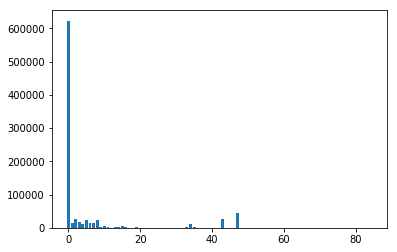

In [38]:
plt.bar(np.arange(len(array)),array)
plt.show()

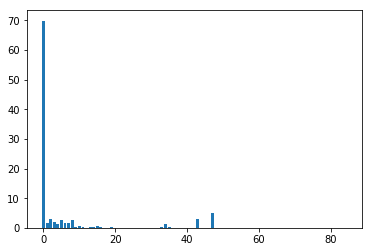

In [39]:
plt.bar(np.arange(len(new_array)),new_array)
plt.show()

In [40]:
low_thresh = 8
high_thresh = 32
azdias_lnans,azdias_mnans, azdias_hnans = analyze_nan_rows(azdias_copy,low_thresh,high_thresh)

Percentage of rows with missing values less then or euqal to 8 is  86.5891849496365
Percentage of rows with missing values between 8 and 32 is  2.981864206521166
Percentage of rows with missing values more then 32 is  10.428950843842324


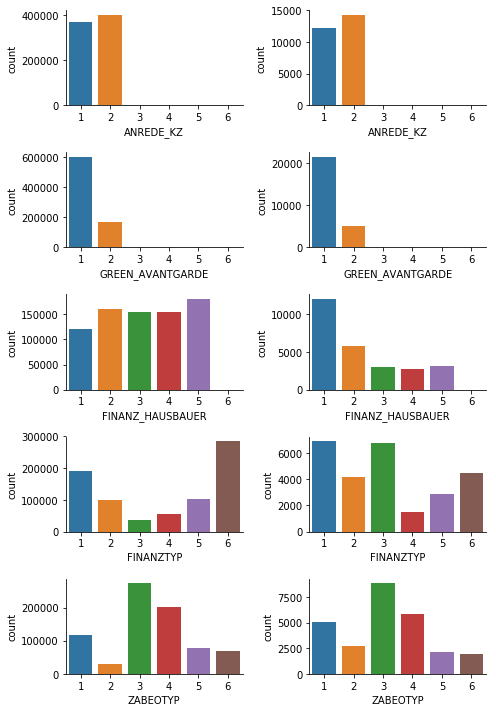

In [41]:

# Set up the matplotlib figure
f, axes = plt.subplots(5, 2, figsize=(7,10), sharex=True)
sns.despine()

sns.countplot(azdias_lnans['ANREDE_KZ'], ax=axes[0, 0])
sns.countplot(azdias_mnans['ANREDE_KZ'], ax=axes[0, 1])

sns.countplot(azdias_lnans['GREEN_AVANTGARDE'], ax=axes[1, 0])
sns.countplot(azdias_mnans['GREEN_AVANTGARDE'], ax=axes[1, 1])

sns.countplot(azdias_lnans['FINANZ_HAUSBAUER'], ax=axes[2, 0])
sns.countplot(azdias_mnans['FINANZ_HAUSBAUER'], ax=axes[2, 1])

sns.countplot(azdias_lnans['FINANZTYP'], ax=axes[3, 0])
sns.countplot(azdias_mnans['FINANZTYP'], ax=axes[3, 1])

sns.countplot(azdias_lnans['ZABEOTYP'], ax=axes[4, 0])
sns.countplot(azdias_mnans['ZABEOTYP'], ax=axes[4, 1])


plt.tight_layout()


From the charts and output shown above, we can see that the number of rows with missing values is very high in range[1,8]. I created a first subset with [0-8] missing values. For rows with missing values [9,32], second subset is created. After comparing the first two subsets, we can see that the distribution of features is very similar for features related to gender and age but different for features related to financial spending. It seems it represent another cluster.

### NOTE: This is done as the previous reviewer suggested to look into this range. Next, I will create two subsets from the dataset after removing the outlier columns. Only two and not three subsets are being created next as suggested in the rubric. 

In [42]:
azdias_lnans, azdias_hnans = create_subsets(azdias_copy,low_thresh)

In [43]:
# Get the no nan containing columns' names in the subset containing nans
columns = []
for i in azdias_lnans:
    if azdias_lnans[i].isnull().sum()==0:
        columns.append(i)

In [44]:
columns

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'ZABEOTYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'WOHNDAUER_2008',
 'GEBAEUDETYP',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'ONLINE_AFFINITAET']

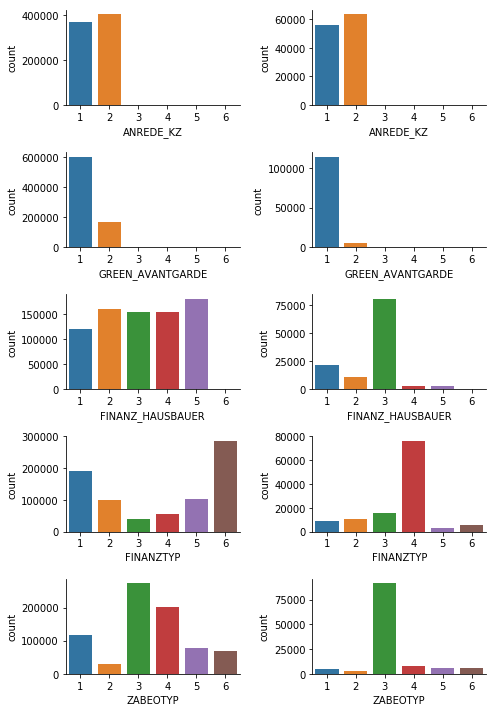

In [45]:
# Set up the matplotlib figure
f, axes = plt.subplots(5, 2, figsize=(7,10), sharex=True)
sns.despine()

sns.countplot(azdias_lnans['ANREDE_KZ'], ax=axes[0, 0])
sns.countplot(azdias_hnans['ANREDE_KZ'], ax=axes[0, 1])

sns.countplot(azdias_lnans['GREEN_AVANTGARDE'], ax=axes[1, 0])
sns.countplot(azdias_hnans['GREEN_AVANTGARDE'], ax=axes[1, 1])

sns.countplot(azdias_lnans['FINANZ_HAUSBAUER'], ax=axes[2, 0])
sns.countplot(azdias_hnans['FINANZ_HAUSBAUER'], ax=axes[2, 1])

sns.countplot(azdias_lnans['FINANZTYP'], ax=axes[3, 0])
sns.countplot(azdias_hnans['FINANZTYP'], ax=axes[3, 1])

sns.countplot(azdias_lnans['ZABEOTYP'], ax=axes[4, 0])
sns.countplot(azdias_hnans['ZABEOTYP'], ax=axes[4, 1])


plt.tight_layout()

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

These are the stats:
- Total Number of rows                        891221
- Total Number of rows with atleast one nan   268012
- Total Number of rows without any nan        623209
- Percentage of rows with atleast one nan 30.07 %


- Percentage of rows with missing values less then or euqal to 8 is  86.59 %
- Percentage of rows with missing values between 8 and 32 is  2.98 %
- Percentage of rows with missing values more then 32 is  10.43 %

[Discussion from cell 41]

From the charts and output shown above, we can see that the number of rows with missing values is very high in range[1,8]. I created a first subset with [0-8] missing values. For rows with missing values [9,32], second subset is created. After comparing the first two subsets, we can see that the distribution of features is very similar for features related to gender and age but different for features related to financial spending. It seems it represent another cluster.


Around 30% of the rows contain atleast one or more nan values. After looking at the distribution of data in dataframes which contain LESS THEN OR EQUAL TO 8 nan values and the one with more nan values, it can be stated that overall distribution of the data is not similar for the columns in both subsets.
- Populations are very similar in terms of gender and age(youth). 
- FINANZTYP which is describes the most descriptive financial type for individual shows that its distribution in both subsets is different. Same is the case with the details of home ownership. 
- For energy consumption typology, we can also see that here the distribution is clearly different. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [46]:
## Droping these columns as 'LP_FAMILIE_GROB', 'LP_STATUS_GROB','LP_LEBENSPHASE_GROB'contains 
## the information in more detail,
## represented by 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN' , 'LP_LEBENSPHASE_FEIN'
azdias_copy_nonans = azdias_copy[azdias_copy.isnull().sum(axis=1)==0]
azdias_copy_nonans = azdias_copy_nonans.drop(['LP_FAMILIE_GROB', 'LP_STATUS_GROB','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN'], axis=1)


In [47]:
# How many features are there of each data type?

categorical = get_column_type_list(azdias_copy_nonans,feat_info, 'categorical')
mixed = get_column_type_list(azdias_copy_nonans,feat_info, 'mixed')

print("Number of Categorical Features: ",len(categorical))
print("Number of Mixed Features: ",len(mixed))
    
    

Number of Categorical Features:  16
Number of Mixed Features:  4


In [48]:
for col in categorical:
    print(col," ",azdias_copy_nonans[col].unique())

ANREDE_KZ   [2 1]
CJT_GESAMTTYP   [ 5.  3.  2.  4.  1.  6.]
FINANZTYP   [1 5 2 4 6 3]
GFK_URLAUBERTYP   [ 10.   5.   1.  12.   9.   3.   8.  11.   4.   7.   6.   2.]
GREEN_AVANTGARDE   [0 1]
LP_FAMILIE_FEIN   [  5.   1.  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_STATUS_FEIN   [  2.   3.   4.   1.  10.   9.   5.   6.   7.   8.]
NATIONALITAET_KZ   [ 1.  2.  3.]
SHOPPER_TYP   [ 3.  2.  0.  1.]
SOHO_KZ   [ 1.  0.]
VERS_TYP   [ 2.  1.]
ZABEOTYP   [5 4 1 6 3 2]
GEBAEUDETYP   [ 8.  1.  3.  5.]
OST_WEST_KZ   ['W' 'O']
CAMEO_DEUG_2015   ['8' '4' '6' '2' '1' '9' '5' '7' '3']
CAMEO_DEU_2015   ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '9B' '1B' '8B' '7A'
 '3D' '4E' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '5C' '9C' '7D' '5E' '1D' '8D'
 '6C' '5B' '7C' '4D' '3A' '2B' '7E' '4B' '2A' '3B' '6F' '5F' '1C' '6A']


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [49]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

azdias_copy_nonans.OST_WEST_KZ.loc[azdias_copy_nonans['OST_WEST_KZ']=='O']=0
azdias_copy_nonans.OST_WEST_KZ.loc[azdias_copy_nonans['OST_WEST_KZ']=='W']=1

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [50]:
# Re-encode categorical variable(s) to be kept in the analysis.

for col in categorical:
    if len(azdias_copy_nonans[col].unique())<3:
        categorical.remove(col)
        
len(categorical)

12

In [51]:

azdias_ohe = pd.get_dummies(azdias_copy_nonans, columns=categorical, drop_first=False)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

## - For binary (two-level) categoricals that take numeric values, no change is made.
## - 'OST_WEST_KZ' is one binary variable that takes on non-numeric values. For this one, I re-encoded the values as numbers.
## - For multi-level categoricals (three or more values), I created the dummy variables. 
## - I dropped the columns 'LP_FAMILIE_GROB' and 'LP_STATUS_GROB' as their information is present in more detail in 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN'.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [52]:
# Please, check how I used the results of my investigation in the functions above to vreate new variables

azdias_ohe = create_decade_column(azdias_ohe)
azdias_ohe = create_mainstream_column(azdias_ohe)
azdias_ohe = create_wealth_column(azdias_ohe)
azdias_ohe = create_life_typology_column(azdias_ohe)
azdias_ohe = create_plz8_business_column(azdias_ohe)
azdias_ohe = create_wohnlage_rural_column(azdias_ohe)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [53]:

azdias_ohe = pd.get_dummies(azdias_ohe, columns=['Decade'], drop_first=False)
azdias_ohe = azdias_ohe.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015','PLZ8_BAUMAX'], axis=1)


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

## I created two new variables for each of the 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'. After that I removed these two variables for the dataset. All the other mixed type variables were kept.  
- For decade, a categorical variable I had to create variables of type interval. 
- Mainstream, a binary variable is defined from the value for 'PRAEGENDE' in 'PRAEGENDE_JUGENDJAHRE'. If the value is 1 for 'PRAEGENDE', Mainstram value is set to 1, 0 otherwise. 
- I defined the two new ordinal variables from 'CAMEO_INTL_2015'. 

- PLZ8_BAUMAX which represents the most common building type within the PLZ8 region.
    -  1: unknown
    -  0: unknown
    -  1: mainly 1-2 family homes
    -  2: mainly 3-5 family homes
    -  3: mainly 6-10 family homes
    -  4: mainly 10+ family homes
    -  5: mainly business buildings

    It has the above mentioned possible values. First two categories resulted in replacement with nans. I just created a binary feature describing if the PLZ8 Region mostly represent business buildings or not. I am ignoring the other categories(1-4), as that information is already contained in the other features like PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4. So, after creating a new variable, I dropped the PLZ8_BAUMAX feature. 

- WOHNLAGE which represents the Neighborhood quality (or rural flag).
    - -1: unknown
    -  0: no score calculated
    -  1: very good neighborhood
    -  2: good neighborhood
    -  3: average neighborhood
    -  4: poor neighborhood
    -  5: very poor neighborhood
    -  7: rural neighborhood
    -  8: new building in rural neighborhood

    It has the above mentioned possible values. First category resulted in replacement with nans. I am creating a binary feature to represent if the neighborhood is private or not. I will keep the WOHNLAGE as an ordinal variable with categoris (0,1,2,3,4,5). Rows in WOHNLAGE with rural neighborhood representing categories (7,8) will be updated to 0.  

- As shown above in the beginning of Step 1.2, 'LP_LEBENSPHASE_FEIN' is removed because most of it's information is detailed in 'LP_FAMILIE_FEIN' and 'LP_STATUS_FEIN'.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [54]:
def clean_data(azdias,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # for easier indexing
    feat_info.index = azdias.columns
    
    # convert missing or uknown values to nans
    azdias = convert_missing(azdias,feat_info)
    
    # get the stats relating nans
    stats = get_missing_value_stats(azdias,feat_info)
    azdias_copy = azdias.copy()
    
    ## remove the six most nan values containing columns
    azdias_copy.drop(stats.head(6).index, axis=1, inplace=True)
    
    # creating subsets with and without nans
    azdias_copy_nonans = azdias_copy[azdias_copy.isnull().sum(axis=1)==0]
    azdias_copy_nans = azdias_copy[azdias_copy.isnull().sum(axis=1)>0]

    ## Droping these columns as 'LP_FAMILIE_GROB', 'LP_STATUS_GROB','LP_LEBENSPHASE_GROB'contains 
    ## the information in more detail,
    ## represented by 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN' , 'LP_LEBENSPHASE_FEIN'
    ## 'LP_LEBENSPHASE_FEIN' is removed because most of this information is detailed in 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN'
    azdias_copy_nonans = azdias_copy_nonans.drop(['LP_FAMILIE_GROB', 'LP_STATUS_GROB','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN'], axis=1)

    
    # getting the list of columns with type 'categorical' or 'mixed'
    categorical = get_column_type_list(azdias_copy_nonans,feat_info, 'categorical')
    mixed = get_column_type_list(azdias_copy_nonans,feat_info, 'mixed')

    # discarding the categorical variables with less then 3 categories
    # the updatedlist will help at the time of one hot encoding
    for col in categorical:
        if len(azdias_copy_nonans[col].unique())<3:
            categorical.remove(col)

    # converting to numberi values
    azdias_copy_nonans.OST_WEST_KZ.loc[azdias_copy_nonans['OST_WEST_KZ']=='O']=0
    azdias_copy_nonans.OST_WEST_KZ.loc[azdias_copy_nonans['OST_WEST_KZ']=='W']=1
    
    # one hot encoding
    azdias_ohe = pd.get_dummies(azdias_copy_nonans, columns=categorical, drop_first=False)

    # creating new columns
    azdias_ohe = create_decade_column(azdias_ohe)
    azdias_ohe = create_mainstream_column(azdias_ohe)
    azdias_ohe = create_wealth_column(azdias_ohe)
    azdias_ohe = create_life_typology_column(azdias_ohe)
    azdias_ohe = create_plz8_business_column(azdias_ohe)
    azdias_ohe = create_wohnlage_rural_column(azdias_ohe)
    
    azdias_ohe = pd.get_dummies(azdias_ohe, columns=['Decade'], drop_first=False)
    azdias_ohe = azdias_ohe.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015','PLZ8_BAUMAX'], axis=1)
    
    return azdias_ohe

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [55]:
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",';')
azdias_ohe = clean_data(azdias,feat_info)


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [56]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scale = scaler.fit_transform(azdias_ohe)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

## Dataset does not contain nans as the rows with nans were removed. Standard scaling is applied on the data. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# to store the intermediate results. 
azdias_ohe.to_csv("azdias_ohe.csv", sep='\t')

In [58]:
for i in range(100, 145, 5):
    pca, X_pca = do_pca(i, azdias_ohe)
    print(i, "  ", pca.explained_variance_ratio_.sum())

100    0.868233212525
105    0.89136969198
110    0.911843094237
115    0.930056668565
120    0.945326141108
125    0.957589555239
130    0.967965548001
135    0.97585350969
140    0.982277129277


In [100]:
pca = PCA(125)
X_pca = pca.fit_transform(azdias_ohe)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

## I have applied PCA for more then 10 times and I found out that 125 is the number best capturing the variability of most of the dataset while reducing the number of features. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

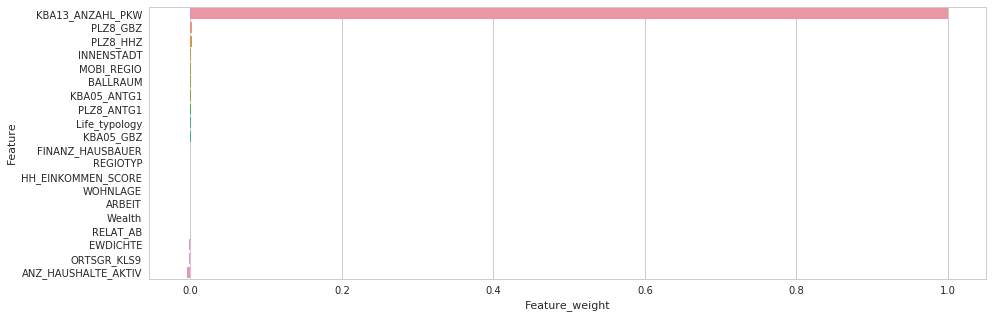

In [101]:
# Functions are defined in the beginning. Second parameter in the pca_component_analysis is the number of features 
# to be visulaizedfrom the head and tail of the principal component. 

plot_pca_component(pca_component_analysis(azdias_ohe,pca.components_[0],10))

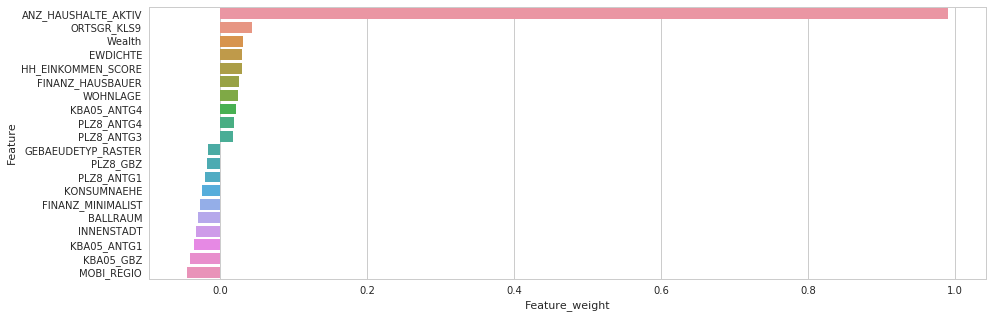

In [102]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_pca_component(pca_component_analysis(azdias_ohe,pca.components_[1],10))

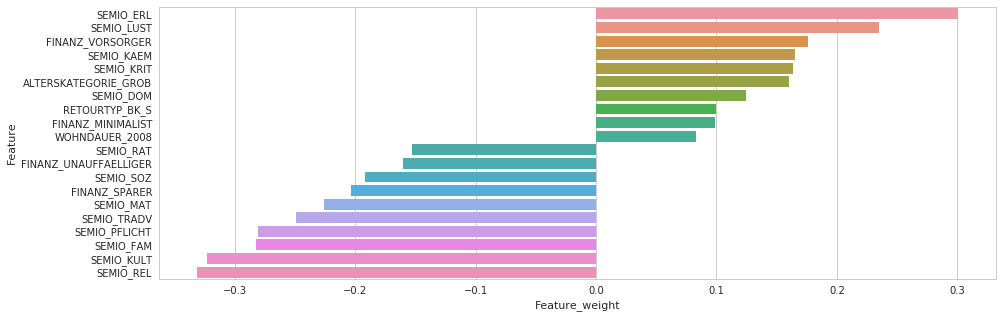

In [103]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_pca_component(pca_component_analysis(azdias_ohe,pca.components_[2],10))

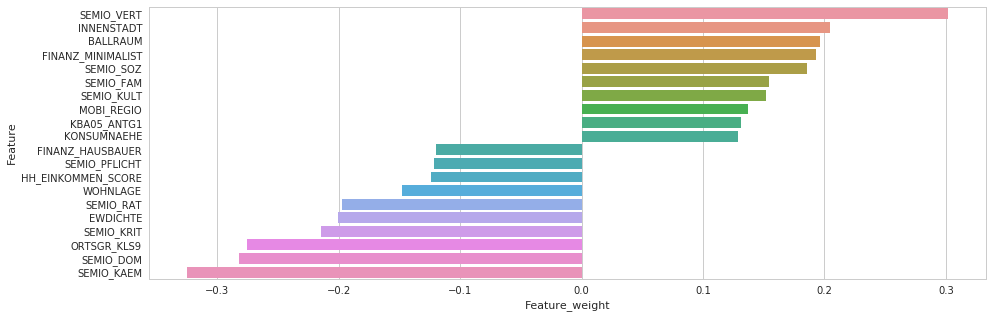

In [104]:
plot_pca_component(pca_component_analysis(azdias_ohe,pca.components_[3],10))

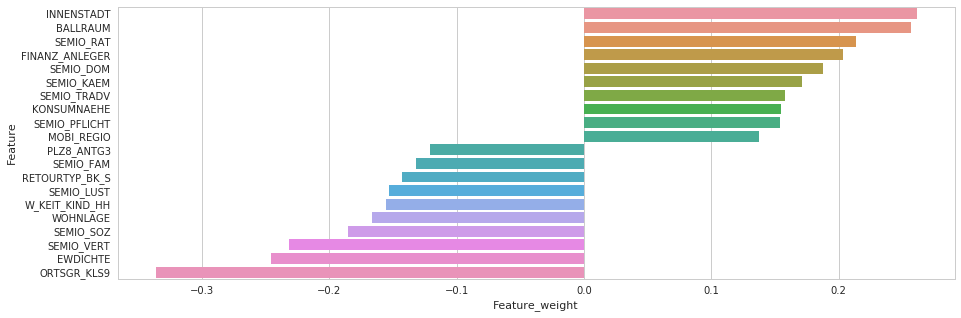

In [105]:
plot_pca_component(pca_component_analysis(azdias_ohe,pca.components_[4],10))

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

- For the first PCA component, KBA13_ANZAHL_PKW which represent the Number of cars in the PLZ8 region is most important. In countries with major car manufacturers, such as USA or Germany, a certain degree of car dependency might be positive for the economy at a macroeconomic level, since it demands automobile production, therefore resulting also in job demand and tax revenue. 
- For the second PCA component, the most important feature with positive weight is ANZ_HAUSHALTE_AKTIV which counts the Number of households in the building. 
- Fourth component shows that SEMIO_VERT(dreamful attitide) and SEMIO_KAEM(combative attitude) are somewhat oppsoite personality attributes. 
- In the fifth component for example, BALLRAUM which represents the Distance to nearest urban center is negativly correlaed to ORTSGR_KLS9 which represents the Size of community. This may be due to gentrification and redevelopment of neighborhoods closer to the city center.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [106]:
def get_kmeans_score(data, center):
    '''
    taken from the lessons
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

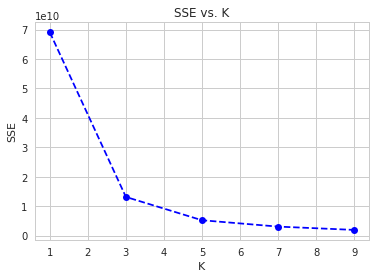

In [107]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    

scores = []
centers = list(range(1, 10, 2))

for center in centers:
    scores.append(get_kmeans_score(X_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [109]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

model = KMeans(n_clusters=4)
predictions = model.fit_predict(X_pca)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

## Using the elbo method, I think the number of optimal clusters should be 4 or 5. After testing, I think 5 is the appropriate number of clusters for this dataset.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [110]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv",';')

In [111]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_ohe = clean_data(customers,feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [112]:
set(azdias_ohe)  - set(customers_ohe)

{'GEBAEUDETYP_5.0'}

In [113]:
## This feature was added as in the customer dataset no row with value of 5.0 for column GEBAEUDETYP was present. 
customers_ohe['GEBAEUDETYP_5.0']=0


In [114]:
scalet = scaler.transform(customers_ohe)

In [115]:
y_pca = pca.transform(customers_ohe)

In [116]:
predictions_y = model.predict(y_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [117]:
unique_gen, counts_gen = np.unique(predictions, return_counts=True)

print (np.asarray((unique_gen, counts_gen)).T)

[[     0 242098]
 [     1 116000]
 [     2  31582]
 [     3 233529]]


In [118]:
ratio_gen = counts_gen/counts_gen.sum()
ratio_gen

array([ 0.38847   ,  0.18613338,  0.05067642,  0.3747202 ])

In [119]:
unique_cus, counts_cus = np.unique(predictions_y, return_counts=True)

print (np.asarray((unique_cus, counts_cus)).T)

[[    0 48612]
 [    1 25331]
 [    2  7170]
 [    3 34530]]


In [120]:
ratio_cus = counts_cus/counts_cus.sum()
ratio_cus

array([ 0.42036267,  0.21904482,  0.06200116,  0.29859135])

In [121]:
a = np.concatenate([unique_cus,unique_gen])
b = np.concatenate([ratio_cus,ratio_gen])
c = np.array([0,0,0,0,1,1,1,1])

In [122]:

df = pd.DataFrame({'Cluster':a,'Ratios':b,'General Population':c})
df

,Cluster,General Population,Ratios
0,0,0,0.420363
1,1,0,0.219045
2,2,0,0.062001
3,3,0,0.298591
4,0,1,0.388470
5,1,1,0.186133
6,2,1,0.050676
7,3,1,0.374720


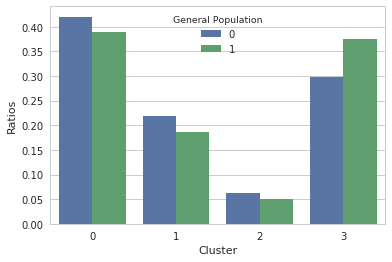

In [123]:

ax = sns.barplot(x="Cluster", y="Ratios", hue="General Population", data=df)


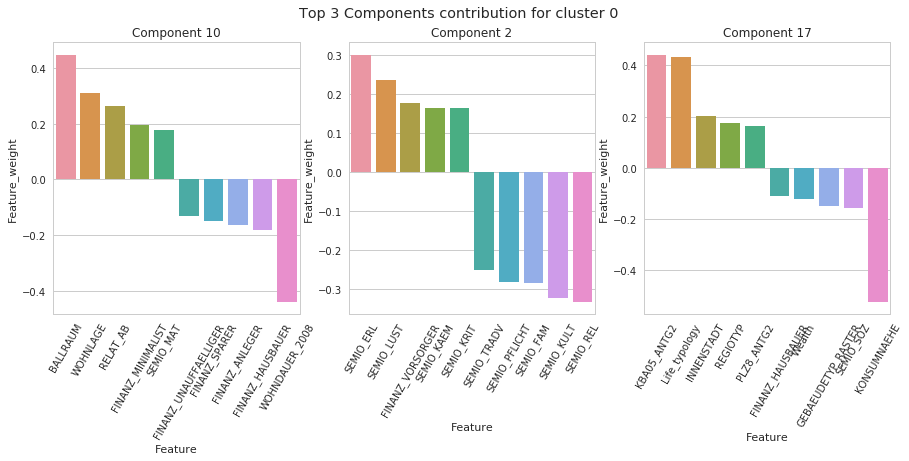

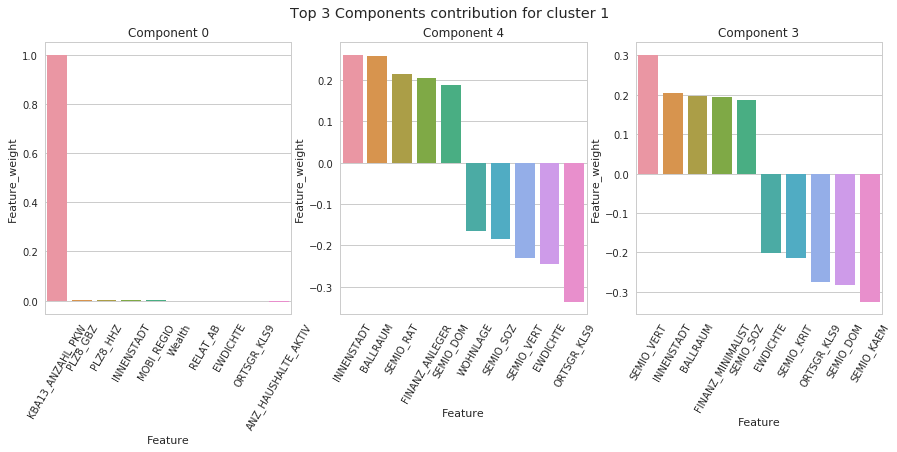

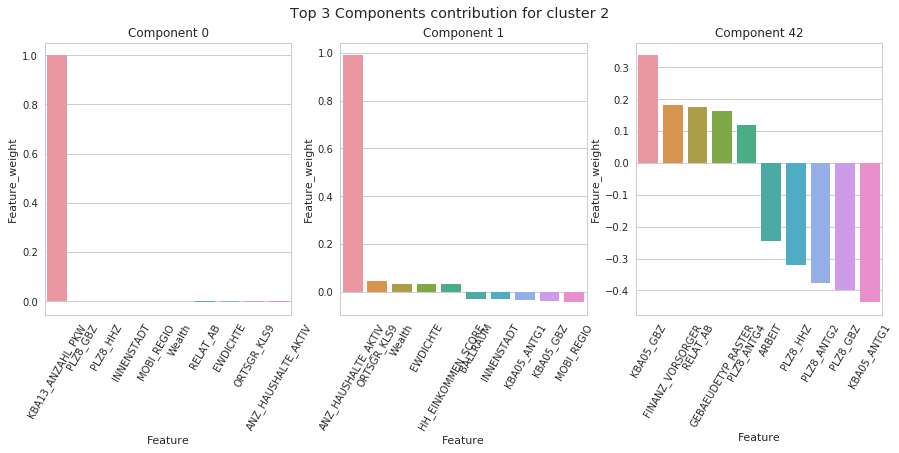

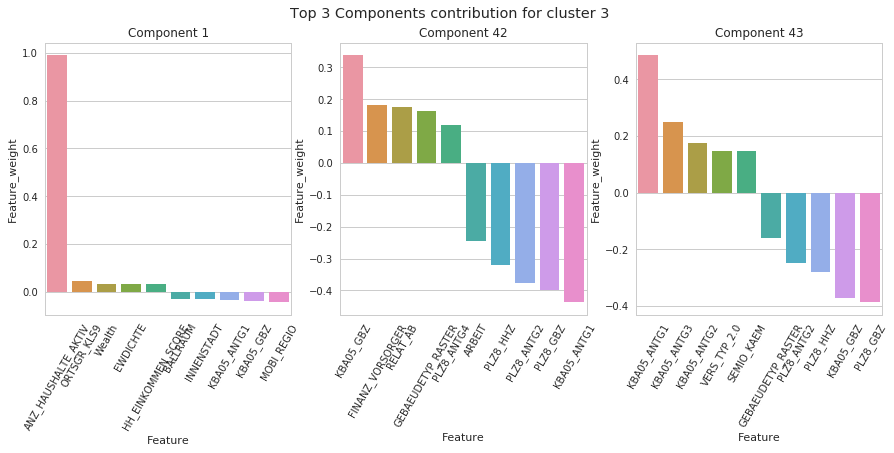

In [124]:
for k in range(4):
    indices = (-model.cluster_centers_[k]).argsort()[:3]
    pca_component_list = []
    for i in indices:
        pca_component_list.append(pca.components_[i])
    plot_multiple_pca_components(multiple_pca_component_analysis(azdias_ohe,pca_component_list,5),k,indices)


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

- I think the company's customer base is universal as the cluster assignment proportions are fairly similar between the two. All clusters except cluster 3 have a bit higher proportions for the customer data that suggests the people in those clusters to be a target audience for the company. On the other hand, as the proportion of the data in cluster 4 is higher for the general population, it suggests that group of people to be outside of the target demographics.
- The visualization I shared above is self explanatory in terms of the detailing which PCA components and the corresponding features contributed the most in identifying the clusters. Please, also refer to Step 2.3, as it shows the analysis of PCA components which are relevant here. 
- Cluster 0 is representing people living further away from the city center with seemingly good neighborhood quality. People are more event oriented and less relegious. They seem to live in the area with 3-5 family homes buildings. 
- Cluseter 1 contain people with higher number of cars in their PLZ8 region and live in buildings where the number of households is low. It means more people from this group are living in indenpdent houses. Thesepeople live away from the city center and live in the communities with less population. 
- Cluster 2 is representing people with higher number of cars in their PLZ8 region and contrary to the previous cluster, they live in buildings where the number of households is above average/high. They live in a microcell with high number of buildings and low share of 1-2 family homes.
- Cluster 3 represents people who live in buildings where the number of households is above average/high. They live in a microcell with high number of buildings, low share of 1-2 family homes and low business share in the area.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.